In [1]:
%run setup
%load_ext autoreload
%autoreload 2

In [108]:
from IPython.display import Image
from pathlib import Path
from nlp_intro.data import draw_uniform_data
from nlp_intro.figure_factory import Linear2D2ClassModelPlotter, plot_3d_scatter, gradient_descent_animation, plot_as_image, create_confusion_matrix_fig, create_text_scatter_plots, create_word_embeddings_fig_from_words, create_scatter_plot_fig
from nlp_intro.gensim_ngram_vectorizers import NgramCountVectorizer
from nlp_intro.doc_vectorizer import DocVectorizer
from nlp_intro.logistic_regression import gradient
from nlp_intro.data import load_diskusjon_no_data
from nlp_intro.my_multiprocessing import process
from nlp_intro.helper_functions import print_with_highlighting
from nlp_intro.transformers import TextReplacer, RegexReplacer, StopwordRemover, RegexStopwordRemover
from nlp_intro.text_diff import text_diff
import pandas as pd
import numpy as np
from ipywidgets import interact, Output, VBox
import plotly.graph_objects as go
import warnings
import re
import spacy
import scattertext as st
from IPython.display import IFrame
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models.wrappers import FastText
from gensim.models.phrases import Phrases, Phraser
from collections import Counter
import numpy as np
import scipy.sparse
from sklearn.pipeline import make_union, make_pipeline
from sklearn_pandas import DataFrameMapper
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import sklearn.datasets
from bs4 import BeautifulSoup
import requests
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
import skift
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from plotly.offline import iplot

In [32]:
STOP_WORDS = spacy.lang.nb.stop_words.STOP_WORDS

In [15]:
nlp = spacy.load("nb_core_news_sm")

In [59]:
warnings.filterwarnings("ignore")

In [8]:
root_dir = Path("..").resolve()

# En introduksjon til språkprosessering med maskinlæring

15.08.19 / Peter Sandberg

# Om meg

- Ferdig på NTNU i 2016, Indøk Data m/Kunstig Intelligens
- Jobbet som Data Scientist i Visma siden da
- Stort sett gjort språkprosessering de siste 3 årene

# Motivasjon

- Store deler av mennneskehetens samlede kunnskap finnes i tekstlige, ikke-strukturerte dokumenter
    - Et *dokument* kan være alt fra en tweet til en hel vitnekapelig artikkel, avhengig av problemet du prøver å løse
- Mer tekstdata genereres hver dag enn én person kan rekke å lese hele sitt liv
- Mange virkelige datasett er delvis tekst, og disse teknikkene kan brukes for å hente ut "featres" fra denne teksten
- Det *skjer* veldig mye innen NLP om dagen, det er mange flere "åpne" problemstillinger her enn andre felter - noe som gjør det veldig spennende å følge med på utviklingen

Og ikke minst: om vi noen gang skal ha håp om å kommunisere med datamaskiner må vi gjøre dem i stand til å forstå språket vi bruker

<center> <img src="../images/a-day-in-data.jpg"/> </center>

# Vanlige problemstillinger

- Tekstklassifisering
    - Sentiment, språk, spam vs. ikke osv
- Part-of-speech tagging
- Named entity recognition
- Dependency parsing
- Tekstoppsummering
- Topic modelling
- Language modelling/generation
- Spørsmålsbesvaring
- Språkgjenkjenning
- Oversetting

# Mål for presentasjonen

- Kommer ikke til å gå i dybden på hver algoritme som brukes - flere av algoritmene kunne vi dedikert en helt egen fagkveld til
- Å diskutere forskjellige maskinlæringsalgoritmer vil *ikke* være i fokus. Vi vil bruke mest tid på tekstprosessering og tekstrepresentasjon, det som er unikt for NLP - maskinlæringsalgoritmene er de samme uavhengig av fagområde.
- Målet med presentasjonen er å:
    - Demystifisere NLP - gi deg en forståelse av hvordan ulike NLP-problemstillinger løses
    - Gi en praktisk introduksjon til temaet gjennom kode

Obs: om du ikke snakker "Python", så ikke fokuser på denne koden. Fokuset vil være på konsepter og ikke kode - det aller meste av koden vil uansett være skjult her i presentasjonen, eller dyttet ut i egne moduler utenfor notebooken.

# To måter å prosessere språk
- Regel-basert
- *Maskinlæringsbasert*

Så denne presentasjonen burde egentlig blitt kalt:

# En introduksjon til språkprosessering *med maskinlæring*

15.08.19 / Peter Sandberg

# Maskinlæring på 5 minutter

# 2 typer maskinlæring

1. **Veiledet læring** (en: supervised learning): metoder for å lære seg en sammenheng mellom data og kategorier/tallverdier tillordnet denne dataen, slik at man gitt ny data kan predikere disse kategoriene/tallverdiene

2. **Ikke-veiledet læring** (en: unsupervised learning): metoder for å finne nyttige mønstre i data

 ## Veiledet læring

 
<center> <img src="../images/bender.gif"/> </center>

Vi har datapunkter $X$ og for hvert datapunkt en kategori/tallverdi $y$. Vi antar at det er en sammenheng mellom $X$ og $y$, slik at $X$ kan brukes for å predikere $y$:
$$X \rightarrow y$$

Ved hjelp av *veiledet læring* ønsker vi å finne denne "pilen"/modellen:
$$X \boxed{\rightarrow} y$$

..slik at gitt nye datapunkter $X_2$ og modellen:
$$X_2 \rightarrow $$

...kan vi produsere prediksjoner for hvert av de nye datapunktene:
$$X_2 \rightarrow y_2$$

## Eksempel: et datasett av bokser

<center> <img src="../images/boxes1.png"  style="height:200px;width:auto;"/> </center>

In [4]:
data = draw_uniform_data(100, (0, 1), (0, 1))
feature_names = ("width", "height")
pd.DataFrame(data, columns=feature_names).head(3)

,width,height
0,0.895346,0.314897
1,0.416592,0.538401
2,0.986537,0.985136


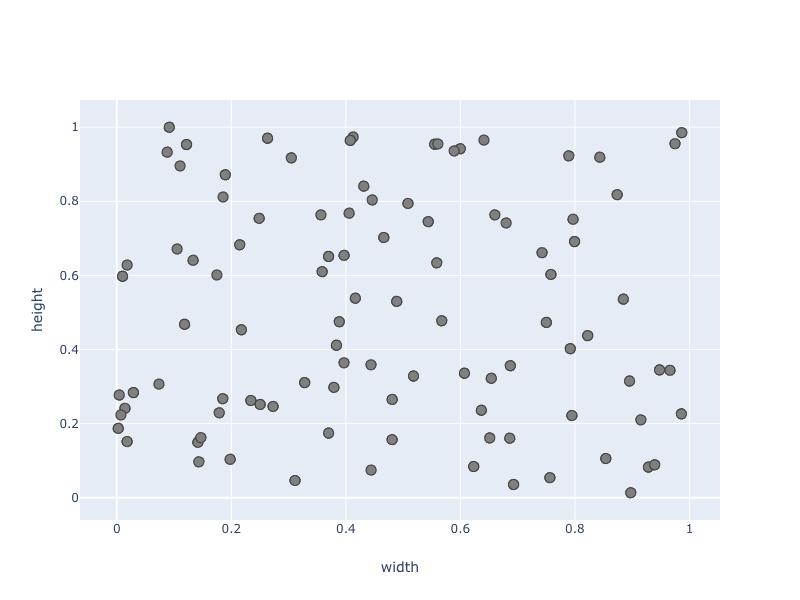

In [5]:
layout = dict(width=800, height=600, yaxis=dict(title_text="height"), xaxis=dict(title_text="width"))
plotter = Linear2D2ClassModelPlotter((0,1), (0,1), layout=layout)
plotter.update_data_plots(data)
plot_as_image(plotter())

### En lineær modell for boks-dataen

Er dette en god modell for boks-dataen vår?

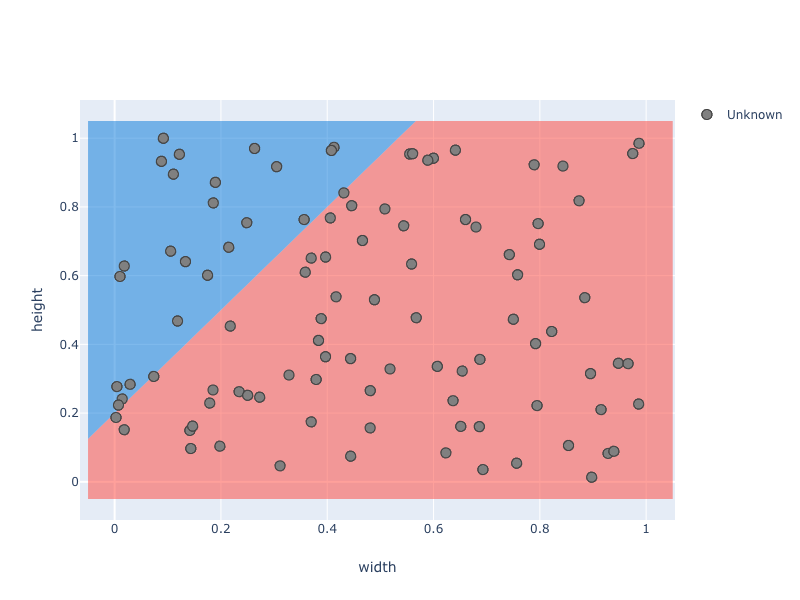

In [6]:
plotter.update_model_area_plots(lambda x: 1.5*x+0.2)
plot_as_image(plotter())

Umulig å vite. For å kunne en veiledet modell trenger vi noe som kan veilede modellen.

In [7]:
def predict(boolean_model, data, class_names):
    label_ids = boolean_model(data)
    label_names = np.asarray(class_names)
    return label_names[label_ids.astype(int)]

### Tagging av hvert datapunkt

- For å veilede modellen vår må hvert punkt tagges med en kategori eller tallverdi.
- Mange potensielle måter å tagge boks-datapunktene våre, men én mulighet er å skille mellom "vide" og "høye" rektangler
- Obs: dette er *ikke* et problem som bør løses med maskinlæring, men det lar seg fint gjøre om man har samlet data med disse taggene

<center> <img src="../images/rectangle-classes.png"  style="height:600px;width:auto;"/> </center>

Vi vil da få et datasett på følgende format:

In [8]:
class_names = ["Tall rectangle", "Wide rectangle"]
model = lambda data: data[:,0] > data[:,1]
labels = predict(model, data, class_names)
pd.DataFrame(np.asarray([*data.T, labels]).T, columns=("width", "height", "class")).head(5)

,width,height,class
0,0.8953460631629142,0.3148974329865626,Wide rectangle
1,0.41659168803512836,0.5384010647096859,Tall rectangle
2,0.9865365122598324,0.9851359496139936,Wide rectangle
3,0.2728945519354834,0.24632392960331118,Wide rectangle
4,0.41271962331326284,0.9735090708637028,Tall rectangle


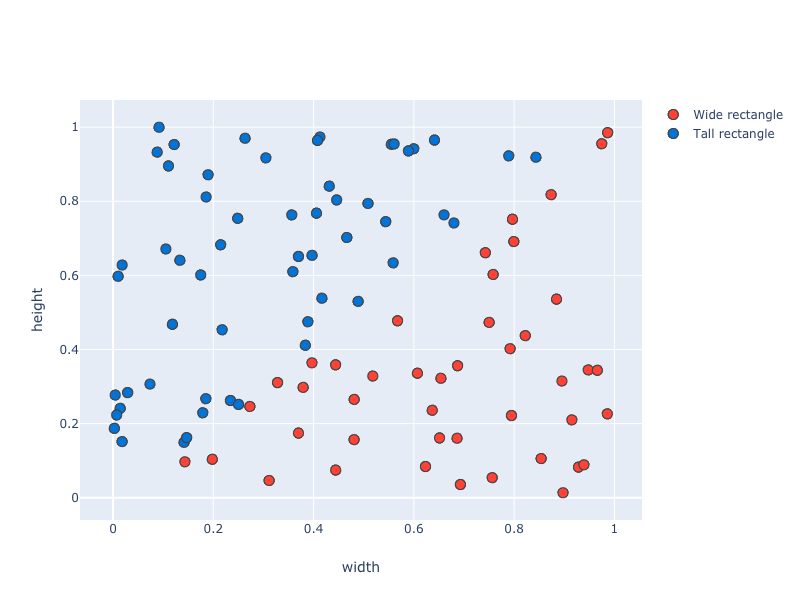

In [9]:
plotter.disable_model_areas()
plotter.update_data_plots(data, labels, unq_classes=class_names[::-1])
plot_as_image(plotter())

### En lineær modell for å skille mellom vide og høye rektangler

For å skille disse punktene fra hverandre kan vi trene en lineær modell vha veiledet læring. Kan vi nå si om modellen er god eller ikke?

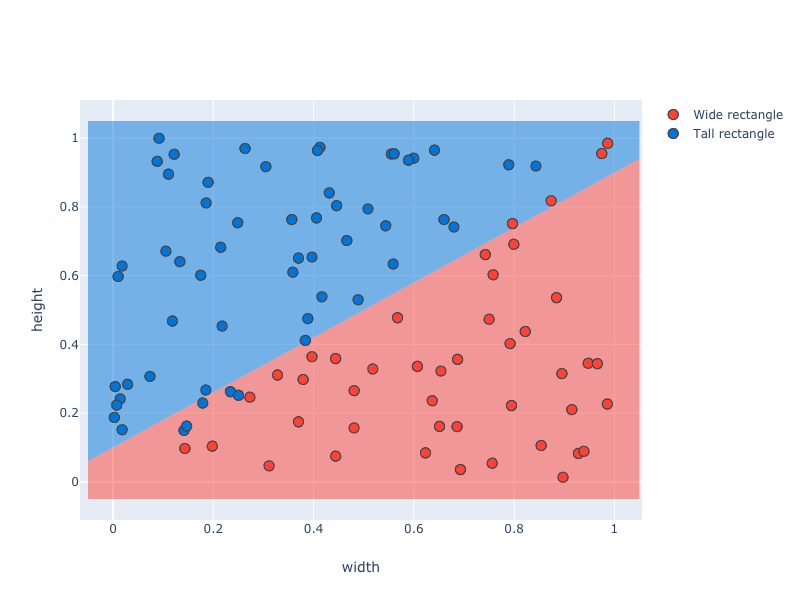

In [10]:
lin_model = lambda x: 0.8*x + 0.1
plotter.enable_model_areas()
plotter.update_model_area_plots(lin_model)
plot_as_image(plotter())

Ja, vi kan nå bruke kategoriene i datasettet vårt for å avgjøre om modellen er god eller om den må justeres.

Med en trent modell kan vi gjøre prediksjoner for nye datapunkter. Vi kan da "kaste vekk" all dataen vi brukte for å trene den.

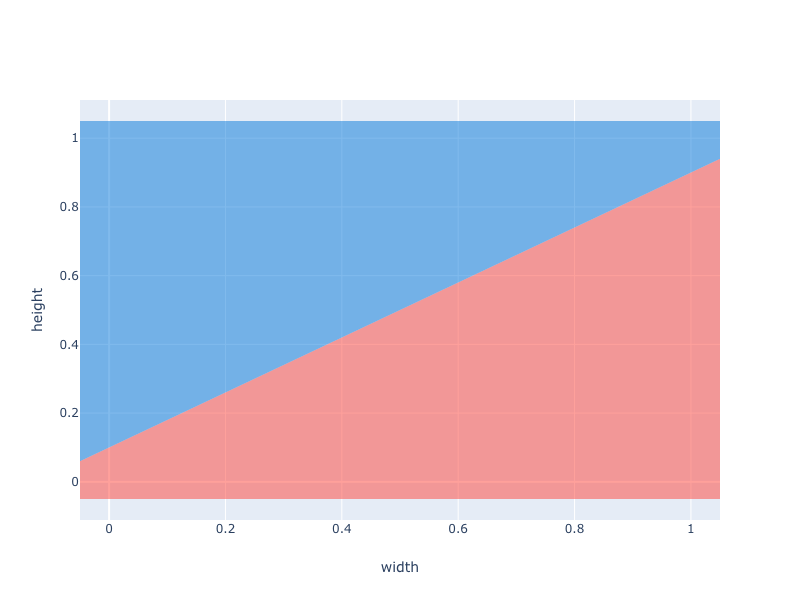

In [11]:
plotter.disable_data_points()
plot_as_image(plotter())

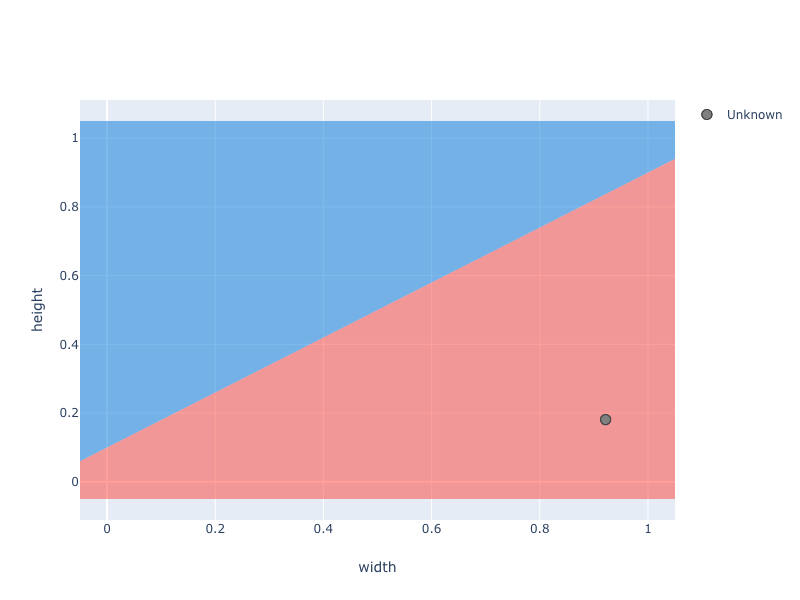

In [12]:
new_data = draw_uniform_data(1, (0,1), (0,1))
plotter.update_data_plots(new_data)
plotter.enable_data_points()
plot_as_image(plotter())

In [13]:
def predict_using_linear_model(lin_model, data, class_names):
    label_ids = (lin_model(data[:,0]) > data[:,1]).astype(int)
    return np.asarray(class_names)[label_ids]

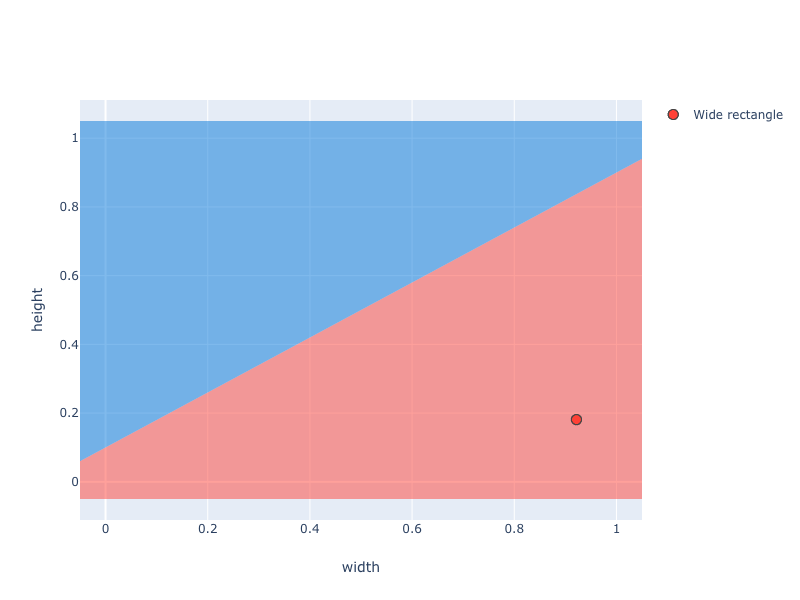

In [14]:
labels = predict_using_linear_model(lin_model, new_data, class_names)
plotter.update_data_plots(new_data, labels, unq_classes=class_names[::-1])
plot_as_image(plotter())

## Hvordan forbedre modellen?

For å finne ut hvordan modellen må endres kan vi definere en *feilfunkson* $E$ og bruke de deriverte av denne funksjonen mht parametere i modellen vår. Den deriverte for en parameter vil peke i retningen vi må endre parameteren for å redusere verdien av feilfunksjonen.

$$
\frac{\partial}{\partial w_i}E(modell, data, klasser)
$$
Hvor modellen er en funksjon av $w_0, w_1,...,w_n$

Link til presentasjon

### Psuedo-algoritme for veiledet læring ved "gradient descent" 

1. Start med en tilfeldig konfigurasjon av modellen
2. Beregn de deriverte (aka gradientene, derav "gradient descent")
3. Bruk disse for å oppdatere modellen
4. Iterer steg 1-3 frem til endringene av modellen fra et steg til det neste blir for små (eller et annet stopp-kriterium er nådd)

<center> <img src="../images/gradient-descent.jpg"/> </center>

La oss teste dette opp boks-dataen vår. Vi vet at den korrekte linjen for å skille høye og vide rektangler vil være:
$$y = w_0*x + w_1 = 1 * x + 0 = x$$

NB: Hvis animasjonen under ikke kommer opp, prøv å gå kjøre "File > Trust Notebook"

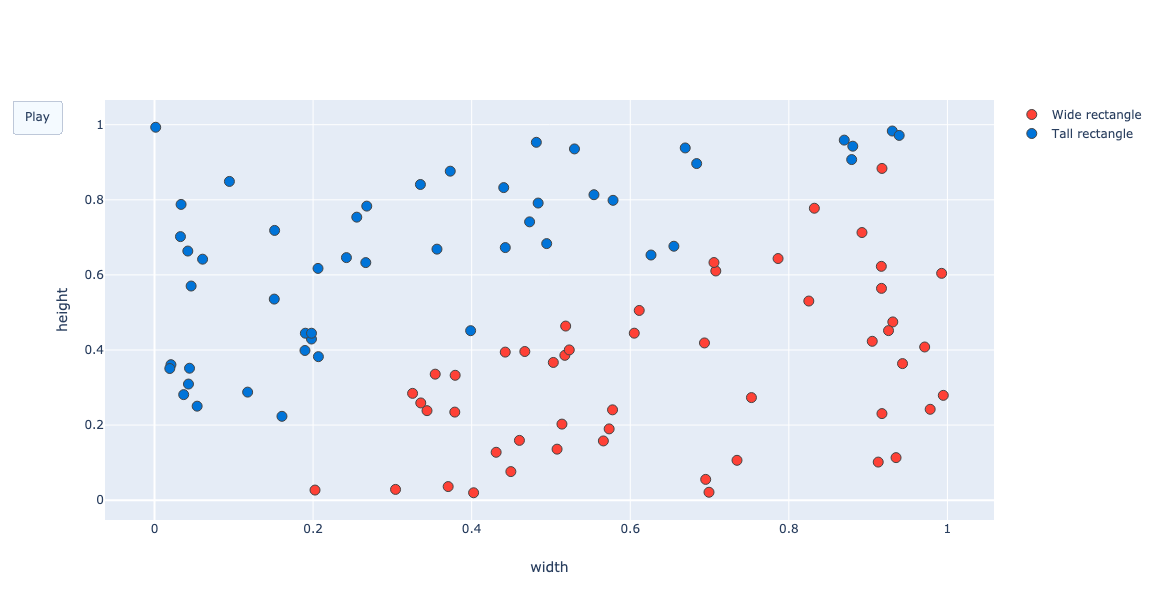

In [15]:
gradient_descent_animation((0, 1), (0, 1), w_real=[1, -1, 0], w_initial=[-0.5, -1, 0.8], lr=1, layout=layout, class_names=class_names, inv_class_names_for_plot=True)

Mer detaljer om en vanlig måte å gjøre veiliedet læring kan dere finne i en tidligere presentasjon jeg har holdt [her](https://docs.google.com/presentation/d/1yEnI_58H1g4kWzAlF6sU6CDgWyDd3oCly8XgjmHDQJE/edit?usp=sharing)

# Ikke-veiledet læring

In [144]:
points, labels = sklearn.datasets.make_blobs(centers=3, shuffle=True, n_samples=300)

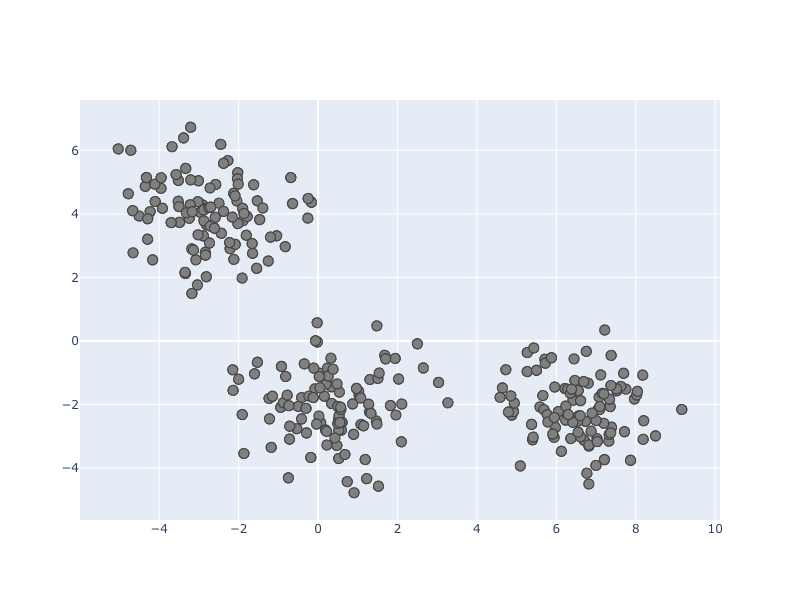

In [147]:
plot_as_image(create_scatter_plot_fig(points, None, layout=dict(width=800, height=600)))

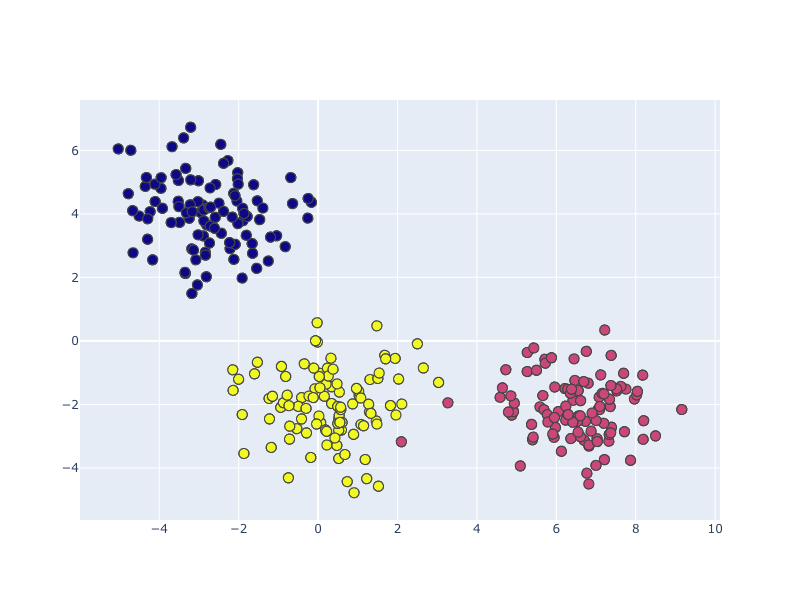

In [149]:
plot_as_image(create_scatter_plot_fig(points, labels, layout=dict(width=800, height=600)))

# Skaffe tekstdata

Flere gode kilder til tekstdata:
- Wikipedia
- Twitter
- Nyheter
- Reddit og andre forum

# Wikiextractor

- Wikipedia har et repository for nedlating av alle artikler (per språk)
- Wikiextractor er en pakke for å ekstrahere denne nedlastede dataen til et brukbart format
- En implementasjon av denne kan du finne i mappen ```nlp_intro.dump_norwegian_wiki.py```

# BeautifulSoup

- [BeautifulSoup](https://pypi.org/project/beautifulsoup4/) er et verktøy for å parse html-filer, og navigere seg gjennom dem
- En cheatsheet for BS kan du finne [her](https://gist.github.com/yoki/b7f2fcef64c893e307c4c59303ead19a)
- Et eksempel for scraping av diskusjon.no kan du finne i ```nlp_intro.diskusjon_no_scraper.py```

In [113]:
soup = BeautifulSoup(requests.get("https://www.vg.no/").text, "html.parser")

In [120]:
soup.select_one('h3[itemprop="headline"]').find("a").text

'USA: Flere politimenn skutt '

## Data fra diskusjon.no hentet via BeautifulSoup

In [5]:
df = load_diskusjon_no_data(-1)
df.head(3)

,topic_id,create_time,author,title,body,scrape_time,label
0,176409,2003-12-03 01:54:54+00:00,EC,Om bilder i worklogs,Worklogs -kategorien krever bilder av prosjekt...,2019-08-12 11:58:35.397080+00:00,Data > Brukerbidrag > Arbeidslogger (data og e...
1,541774,2006-02-22 01:02:03+00:00,blacktower,Slik bruker du arbeidsloggene,Vær snill å lese de nye retningslinjene før du...,2019-08-12 11:58:35.792901+00:00,Data > Brukerbidrag > Arbeidslogger (data og e...
2,257251,2004-06-12 14:24:26+00:00,Boralis,Worklog: Hva bør en tenke på?,Det er blitt veldig populært med worklogger o...,2019-08-12 11:58:36.226868+00:00,Data > Brukerbidrag > Arbeidslogger (data og e...


# Fra tekst til tall

- Alle maskinlæringsmodeller bruker matematikk/statistikk for å finne optimal konfigurasjon
- For å kunne bruke maskinlæring for NLP er vi derfor nødt til å konvertere tekstene til tall
- Mange måter å gjøre dette på:
    - Bag-of-words (BOW)
    - BOW + TF-IDF
    - N-grams (+ TF-IDF)
    - Char n-grams (+ TF-IDF)
    - Word embeddings (word2vec, Glove, fastText)
    - Document embeddings (doc2vec, min/max/mean pooling, RNN encoder)
    - Contextualized word embeddings (ELMO, BERT, Flair)

## Bag-of-words (BOW)

- Tell antall forekomster av hvert enkelt ord, og lag én kolonne per ord
- Hva er et ord? Standard definisjon er som regel "en sammenhengende sekvens av alfanumeriske (a-z, 0-9, _) karakterer"

In [16]:
texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = CountVectorizer()
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,en,er,funker,håper,tekst
0,1,1,1,0,0,1
1,1,0,0,1,1,0


In [17]:
print(texts_vec)

  (0, 0)	1
  (0, 2)	1
  (0, 1)	1
  (0, 5)	1
  (1, 0)	1
  (1, 4)	1
  (1, 3)	1


Alternativt ord-mønster:

In [18]:
vec2 = CountVectorizer(token_pattern="(?:\w+|[^\w\s]+)")
texts_vec2 = vec2.fit_transform(texts)
pd.DataFrame(texts_vec2.todense(), columns=vec2.get_feature_names())

,!,:),dette,en,er,funker,håper,tekst
0,1,0,1,1,1,0,0,1
1,0,1,1,0,0,1,1,0


Tips:
- Jobber du med et domene du kjenner, eller domene-eksperter - bruk kunnskapen din til å forbedre ord-mønsteret ditt.
- F.eks. vil smileys muligens være nyttig å hente ut som egne ord om du bygger en sentiment-klassifiserer.

# "TF-IDF"-vekting av ord
- **TF** (Term frequency): Antall ganger ordet oppstår i en bestemt tekst
- **IDF** (Inverse document frequency): Antall ganger ordet oppstår i alle tekster
- Med TF-IDF vekter vi opp om de oppstår flere ganger i en tekst, og ned om de oppstår ofte i alle tekster
- Intuitivt: et ord som brukes flere ganger i en tekst er sannsynligvis viktig for denne teksten, men om det oppstår ofte i alle tekster er det sannsynligvis bare et vanlig ord i vokabularet og bør vektes ned

Med TF, uten IDF:

In [19]:
texts = ["Ha ha det var morsomt", "Det var veldig, veldig, veldig bra"]
vec3 = TfidfVectorizer(use_idf=False, norm=None)
texts_vec3 = vec3.fit_transform(texts)
pd.DataFrame(texts_vec3.todense(), columns=vec3.get_feature_names())

,bra,det,ha,morsomt,var,veldig
0,0.0,1.0,2.0,1.0,1.0,0.0
1,1.0,1.0,0.0,0.0,1.0,3.0


Med TF og IDF:

In [20]:
vec4 = TfidfVectorizer(use_idf=True, norm=None)
texts_vec4 = vec4.fit_transform(texts)
pd.DataFrame(texts_vec4.todense(), columns=vec4.get_feature_names())

,bra,det,ha,morsomt,var,veldig
0,0.000000,1.0,2.81093,1.405465,1.0,0.000000
1,1.405465,1.0,0.00000,0.000000,1.0,4.216395


# N-grams

- En naturlig utvidelse av bag-of-words er å se på uttrykk som består av mer enn ett ord, såkalte "n-gram"
    - F.eks. "New York", "Amazon Web Services"
- Mest brukt er såkalte *bigrams* og *trigrams*, som består av hhv. 2 og 3 etterfølgende ord. 
    - Man kan se på n-grams av større størrelse, men av erfaring er ofte bigrams nok, noen få ganger trigrams
- Den enkleste formen for generering av n-grams vil være å helt enkelt *generere alle mulige kombinasjoner av ord fra datasettet*

In [21]:
texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = CountVectorizer(ngram_range=(1, 2))
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,dette er,dette funker,en,en tekst,er,er en,funker,håper,håper dette,tekst
0,1,1,0,1,1,1,1,0,0,0,1
1,1,0,1,0,0,0,0,1,1,1,0


Det er dessuten vanlig å kombinere n-grams med TF-IDF vekting:

In [22]:
texts = ["Dette er en tekst!", "håper dette funker :)"]
vec = TfidfVectorizer(ngram_range=(1, 2))
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,dette,dette er,dette funker,en,en tekst,er,er en,funker,håper,håper dette,tekst
0,0.278943,0.392044,0.000000,0.392044,0.392044,0.392044,0.392044,0.000000,0.000000,0.000000,0.392044
1,0.335176,0.000000,0.471078,0.000000,0.000000,0.000000,0.000000,0.471078,0.471078,0.471078,0.000000


## Mer intelligent generering av bigrams 

In [23]:
vec = CountVectorizer(ngram_range=(1, 2))
texts_vec = vec.fit_transform(["Hei på deg. Dette er en test."])
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,deg,deg dette,dette,dette er,en,en test,er,er en,hei,hei på,på,på deg,test
0,1,1,1,1,1,1,1,1,1,1,1,1,1


- Legg merke til kolonne 2 "deg dette". Her har vi fått generert et uttrykk på tvers av setninger. Vi vet at det aldri skal skje. Vi bør splitte tekstene i setninger for mer fornuftig generering av n-grams.
- Vi er dessuten ikke interessert i alle mulige kombinasjoner, kun de som (sannsynligvis) er faktiske uttrykk

## Splitting av setninger

- Å splitte setninger er ikke så enkelt som å bare splitte på punktum, da vil man f.eks. feil ved forkortelser.
- Heldigvis er dette et vanlig problem, og det finnes flere pakker med funksjonalitet for å gjøre dette - også for norsk.

In [97]:
def print_sents(sents):
    for i, sent in enumerate(sents):
        print(f"Sentence {i+1}:", repr(str(sent)))

Spacy har delvis støtte for norsk. Splitting av setinger er blant annet støttet:

In [98]:
sent_pipeline = spacy.lang.nb.Norwegian()
sentencizer = sent_pipeline.create_pipe("sentencizer")
sent_pipeline.add_pipe(sentencizer)
doc = sent_pipeline("Dette er en test. Funker dette? Her har vi f.eks. en forkortelse. Dr. Dre var ")
print_sents(doc.sents)

Sentence 1: 'Dette er en test.'
Sentence 2: 'Funker dette?'
Sentence 3: 'Her har vi f.eks. en forkortelse.'
Sentence 4: 'Dr.'
Sentence 5: 'Dre var'


Polyglot har også full støtte for norsk:

In [26]:
# from polyglot.text import Text
# doc = Text("Dette er en test. Funker dette? Her har vi f.eks. en forkortelse.", hint_language_code="nb")
# print_sents(doc.sentences)

Hva med ekte data?

In [4]:
text = df.body.iloc[1]
print(text)

Vær snill å lese de nye retningslinjene før du poster i loggkategoriene. Den viktigste endringen er:

Plassering
Loggområdet er delt i Arbeidslogger og Arbeidslogger - Kommentarer.
- "Arbeidslogger" en kategorien hvor arbeidsloggen skal føres. Kun de som deltar i prosjektet (som oftest trådstarter) skal poste i denne tråden.
- "Arbeidslogger - Kommentarer" er en kategori hvor du skal opprette en tråd med samme tittel som den du opprettet i "Arbeidslogger", slik at andre kan kommentere ditt arbeide. Her kan alle svare.

Bilder fra loggen skal ikke legges i kommentartråden. Fra første post i kommentartråden linker du til arbeidsloggen, kanskje med et lite bilde.

Alle de gamle trådene er flyttet til " Arbeidslogger - Kommentarer". Trådstarere må gjerne opprette arbeidslogger i "Arbeidslogger" med basis i den gamle tråden (som nå vil fungere som kommentartråd.


In [28]:
doc = sent_pipeline(text)
print_sents(doc.sents)

Sentence 1: 'Vær snill å lese de nye retningslinjene før du poster i loggkategoriene.'
Sentence 2: 'Den viktigste endringen er:\n\nPlassering\nLoggområdet er delt i Arbeidslogger og Arbeidslogger - Kommentarer.'
Sentence 3: '\n- "Arbeidslogger" en kategorien hvor arbeidsloggen skal føres.'
Sentence 4: 'Kun de som deltar i prosjektet (som oftest trådstarter) skal poste i denne tråden.'
Sentence 5: '\n- "Arbeidslogger - Kommentarer" er en kategori hvor du skal opprette en tråd med samme tittel som den du opprettet i "Arbeidslogger", slik at andre kan kommentere ditt arbeide.'
Sentence 6: 'Her kan alle svare.'
Sentence 7: '\n\nBilder fra loggen skal ikke legges i kommentartråden.'
Sentence 8: 'Fra første post i kommentartråden linker du til arbeidsloggen, kanskje med et lite bilde.'
Sentence 9: '\n\nAlle de gamle trådene er flyttet til " Arbeidslogger - Kommentarer".'
Sentence 10: 'Trådstarere må gjerne opprette arbeidslogger i "Arbeidslogger" med basis i den gamle tråden (som nå vil fung

La oss splitte alle postene fra diskusjon.no i setninger. Vi antar at alle post-titler allerede er splittet, så vi dropper å splitte disse.

In [29]:
%%time
def _split_into_sentences(text):
    doc = sent_pipeline(text)
    return [str(sent).strip() for sent in doc.sents]

body_sents = process(_split_into_sentences, df.body)

CPU times: user 249 ms, sys: 67.3 ms, total: 316 ms
Wall time: 8.09 s


## Generering av bigrams fra setningene

In [30]:
all_sents = df.title.tolist() + [s for sentences in body_sents for s in sentences]

In [31]:
len(all_sents)

136643

In [32]:
tokenize = lambda sent: [word.lower() for word in re.findall(r"\w+", sent)]
all_sents_tokens = [tokenize(s) for s in all_sents]
phrases = Phrases(all_sents_tokens, min_count=3, threshold=1, common_terms=STOP_WORDS)
bigram = Phraser(phrases)

In [33]:
bigram[tokenize("Jeg har windows 10 på min gaming pc")]

['jeg', 'har', 'windows_10', 'på', 'min', 'gaming_pc']

La oss se på de mest vanlige bigramene i tekstene våre:

In [34]:
def count_ngrams(phraser, sentences, n=None):
    ngrams_counter = Counter()
    for sent in sentences:
        phrases = phraser[sent]
        tokens = [token for token in phrases if _is_ngram(token, n)]            
        ngrams_counter.update(tokens)
    return ngrams_counter

def _is_ngram(token, n):
    if "_" not in token:
        return False
    if n is None:
        return True
    words = token.split("_")
    return len([w for w in words if w not in STOP_WORDS]) == n


def print_most_common(counter, n):
    for key, count in counter.most_common(n):
        print(f"{key:<20} {count}")

In [35]:
bigrams_counter = count_ngrams(bigram, all_sents_tokens)

Merk at vi vil ha fraser med mer enn to ord, fordi såkalte "stopwords" ikke teller med i antall ord for n-gramet når vi bruker denne algoritmen

In [36]:
print_most_common(bigrams_counter, 30)

https_www            1292
http_www             932
f_eks                837
rett_og_slett        283
diskusjon_no         246
of_the               227
forhånd_takk         221
1_2                  211
windows_10           205
in_the               171
takk_for_svar        166
trenger_hjelp        157
takk_på_forhånd      150
setter_pris          148
anonymous_poster     144
blu_ray              142
2_3                  142
3_5                  137
3_4                  136
finn_no              125
o_l                  122
apple_tv             119
myspace_offisiell    106
canal_digital        105
5_1                  104
2_5                  100
bl_a                 98
1_1                  98
samsung_galaxy       97
tusen_takk           97


## Fra bigrams til trigrams og videre

For å generere trigrams kan vi kjøre samme algoritme som over, rekursivt:

In [37]:
all_sents_bigrams = bigram[all_sents_tokens]
trigram = Phrases(all_sents_bigrams, min_count=3, threshold=1, common_terms=STOP_WORDS)
trigram = Phraser(trigram)

In [38]:
trigrams_counter = count_ngrams(trigram, all_sents_bigrams, n=3)

In [39]:
print_most_common(trigrams_counter, 30)

https_www_komplett   136
anonymous_poster_hash 129
myspace_offisiell_hjemmeside 101
karakter_10_10       56
per_dags_dato        42
karakter_9_10        39
https_www_youtube    37
karakter_8_10        32
lars_von_trier       30
anders_behring_breivik 27
https_www_diskusjo   27
forhånd_takk_for_svar 27
juni_18_00           27
com_http_www         26
https_prisguiden_n   25
karakter_7_10        24
rock_n_roll          24
blu_ray_spiller      21
fritt_til_å_tolke_temaet 21
galleriet_på_akam_no 21
karakter_6_10        21
usb_2_0              20
m_2_ssd              20
f_2_8                19
samarbeider_med_diskusjon_no 19
sporliste_min_mening 19
ipb3_0_oppgr         18
takk_for_all_hjelp   18
forhånd_tusen_takk   18
usb_3_0              17


## En "transformer" for smarte bigrams

For å kunne bruke smarte bigrams, trigrams osv. i en modell er vi nødt til å lage et objekt med tilsvarende API som CountVectorizer. Vi kan gjøre dette ved å modifisere noen av koden til denne klassen. For å se hvordan koden er modifisert, gå til ```nlp_intro.gensim_ngram_vectorizer```.

In [40]:
def transform_with_vec(text, vec):
    assert isinstance(text, str)
    text_vec = vec.transform([text])[0]
    _, ix, values = scipy.sparse.find(text_vec)
    feats = np.asarray(vec.get_feature_names())
    return pd.DataFrame([values], columns=feats[ix])

Normale n-grams:

In [41]:
%%time
text = "Jeg har windows 10 på min gaming pc"
vec1 = CountVectorizer(ngram_range=(1,2))
vec1.fit(df.body)
transform_with_vec(text, vec1)

CPU times: user 7 s, sys: 323 ms, total: 7.32 s
Wall time: 7.33 s


,10,10 på,gaming,gaming pc,har,har windows,jeg,jeg har,min,pc,på,på min,windows,windows 10
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


"Smarte" n-grams:

In [42]:
%%time
vec2 = NgramCountVectorizer(ngram_range=(1,2), phrases_common_terms=STOP_WORDS)
vec2.fit(df.body)
transform_with_vec(text, vec2)

CPU times: user 23.4 s, sys: 533 ms, total: 23.9 s
Wall time: 33.6 s


,10,gaming,gaming_pc,har,jeg,min,pc,på,windows,windows_10
0,1,1,1,1,1,1,1,1,1,1


Mer at prosesseringen tar mye lengre tid, fordi vi både må splitte tekstene i setninger, og gjøre beregninger for å finne bigrams. Bigramene vi får er derimot bedre.

# Char n-grams

- Skandinaviske språk som Norsk har mange sammensatte ord
- Med sammensatte ord får vi veldig mange unike kombinasjoner av ord, som kun brukes et fåtall ganger
- En kjapp test på vokabularet fra norske Wikipedia viste at **50% av alle unike ord kun hadde blitt brukt 1 gang** (!)
- Om vi bruker ord som features kan derfor maskinlæring noen ganger bli vanskelig

In [103]:
def vec_similarity(vec1, vec2):
    if scipy.sparse.issparse(vec1):
        vec1 = _sparse_to_1d(vec1)
    if issparse(vec2):
        vec2 = _sparse_to_1d(vec2)
    vec1, vec2 = vec1 / np.linalg.norm(vec1), vec2 / np.linalg.norm(vec2)
    sim = vec1.dot(vec2.T)
    print(f"Similarity: {sim*100:.2f}%")
    
def _sparse_to_1d(vec):
    return np.asarray(vec.todense()).squeeze() 

In [94]:
vec = CountVectorizer()
texts = ["språkprossesering", "prosessering av språk"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,av,prosessering,språk,språkprossesering
0,0,0,0,1
1,1,1,1,0


In [95]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 0.00%


Ikke bra

I naturlige tekster har vi også ofte skrivefiel:

In [96]:
vec = CountVectorizer()
texts = ["språkprossesering", "språkprosesering"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,språkprosesering,språkprossesering
0,0,1
1,1,0


In [97]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 0.00%


Et alternativ til ord-baserte n-grams er å bruke karakter-baserte n-grams. Vi ønsker da å hente ut alle *sammenhengende sekvenser av bokstaver* fra tekstene:

In [98]:
vec = CountVectorizer(analyzer="char", ngram_range=(4,4))
texts = ["språkprossesering", "prosessering av språk"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,av,spr,av s,erin,eser,esse,g av,ing,kpro,ng a,...,ross,råkp,seri,sese,sess,språ,sser,sses,v sp,åkpr
0,0,0,0,1,1,0,0,0,1,0,...,1,1,1,1,0,1,0,1,0,1
1,1,1,1,1,0,1,1,1,0,1,...,0,0,1,0,1,1,1,0,1,0


In [99]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 37.80%


In [100]:
texts = ["språkprossesering", "språkprosesering"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,erin,eser,kpro,oses,osse,pros,pråk,ring,rose,ross,råkp,seri,sese,språ,sses,åkpr
0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1
1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,0,1


In [101]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 81.54%


## Char n-grams, tips:

- En lengde på 4 funker ofte (av erfaring) bra for char n-grams. Det er et godt midtpunkt mellom:
    - For korte sekvenser, som gjør at "alle" ord vil matche
    - For lange sekvenser, som i praksis vil gi samme resultat som ord-baserte n-grams
- Du kan bytte analyzer til ```char_wb```, som vil si at du kun bruker n-grams innenfor hvert ord, ikke på tvers
- Vær obs på at det du har satt som ```token_pattern``` ignoreres når du bruker char n-grams. Dvs. selv om du setter et token pattern som matcher kun bokstaver, vil char n-grams også inneholde tegnsetting:

"Token pattern" ignoreres for char n-grams:

In [52]:
vec = CountVectorizer(analyzer="char", ngram_range=(4,4), token_pattern="\w+")
text = "Hei, John!"
texts_vec = vec.fit_transform([text])
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,joh,", jo","ei,","hei,","i, j",john,ohn!
0,1,1,1,1,1,1,1


# Word embeddings

- Måten vi hittil har konvertert tekst til tall, kalles ofte en glissen (en: sparse) representasjon av tekst, fordi hvert enkelt ord kun er representert av én verdi i en glissen matrise. 
- Alle ord vil derfor ha samme "likhet"/"forskjellighet"

Samme likhet/forskjellighet for alle ord:

In [102]:
vec = CountVectorizer()
texts = ["Hund", "Katt", "Skrutrekker"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

,hund,katt,skrutrekker
0,1,0,0
1,0,1,0
2,0,0,1


Likhet mellom vektoren for hund og katt:

In [103]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 0.00%


Likhet mellom vektoren for hund og skrutrekker:

In [104]:
vec_similarity(texts_vec[0], texts_vec[2])

Similarity: 0.00%


Det hadde vært fint om vi kunne representert ord på en annen måte, slik at ```likhet(hund, katt)``` > ```likhet(hund, skrutrekker)```

## Word Embeddings - læring av "substitutter"

- "Word embeddings" er en tett (en: dense) måte å representere ord på, fordi vi har 'mverdier i alle kolonner for ordet. F.eks.
vil vektoren for hun være noe som ```[0.1231, 1.3030, 3.2233, ...]```
- Hver kolonne i en WE vektor vill representere en egenskap ved ordet, slik at ord som kan være substitutter for hverandre vil være "nærmere" hverandre
- Maskinlæringsproblemet vi løser for å finne disse vektorene er av typen:
    - Gitt et ord - prediker konteksten til ordet (Skip-gram)
    - Gitt konteksten til odet - prediker ordet (CBOW)

## Skip-gram

Figurer hentet fra: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/

(som forøvrig er en mer detaljert gjennomgang av temaet)

<center> <img src="../images/skip-gram-1.png"/> </center>

<center> <img src="../images/skip-gram-2.png"/> </center>

## Hvordan få tilgang til "word embeddings"

For å bruke "word embeddings", kan vi enten:
1. Trene dem selv på et passende sett med dokumenter (gjerne et stort sett, dvs. mange ord)
2. Laste ned forhåndstrente modeller og bruke disse

NB: hvilket datasett word embeddigene er trent på har mye å si for hvordan embeddingene ender opp. Ord som er like i ett vokabular kan være helt ulike i et annet, om kontreksten de brukes i er ulik.

## Word2Vec word embeddings 

Vi velger her å laste ned en forhåndstrent modell fra http://vectors.nlpl.eu/repository/. Modellen vi bruker er for bokmål og trent på norske tekster fra [CoNLL 17](http://universaldependencies.org/conll17/):

Vi ignorerer unicode feil ved innlasting av modellen, fordi det kan få hele innlastingen til å feile. Se https://github.com/RaRe-Technologies/gensim/wiki/Recipes-&-FAQ#q10-loading-a-word2vec-model-fails-with-unicodedecodeerror-utf-8-codec-cant-decode-bytes-in-position-

In [74]:
w2v_model = KeyedVectors.load_word2vec_format("../resources/embeddings/model.bin", unicode_errors='ignore', binary=True, encoding="utf8")

La oss bli litt bedre kjent med modellen:

In [76]:
w2v_model["hund"].shape

(100,)

In [77]:
w2v_model["hund"][:10]

array([ 4.160294  , -0.7913837 , -4.759459  ,  1.3926575 ,  1.1881433 ,
        4.7561536 ,  1.5202963 , -0.87461686,  2.760311  , -0.37462923],
      dtype=float32)

- Vi ser altså at vi har 100 ulike ikke-null verdier som beskriver ordet "hund"
- Hva disse verdiene er bryr vi oss ikke om - vi er bare interessert i at like ord har like embeddings

Nå som hvert ord har mange ulike "features" kan vi sammenligne dem:

In [78]:
w2v_model.most_similar("hund", topn=5)

[('katt', 0.8834836483001709),
 ('hest', 0.8537960052490234),
 ('hunden', 0.8209482431411743),
 ('valp', 0.8072998523712158),
 ('kanin', 0.8040313124656677)]

In [79]:
w2v_model.most_similar("skrutrekker", topn=5)

[('skiftenøkkel', 0.9227230548858643),
 ('avbitertang', 0.8999788761138916),
 ('brødkniv', 0.8843042254447937),
 ('tapetkniv', 0.8789403438568115),
 ('vinkelsliper', 0.8771433234214783)]

La oss nå bekrefte at vi har en representasjon hvor ```likhet(hund, katt)``` > ```likhet(hund, skrutrekker)```:

In [108]:
print("Hund og katt, ", end="")
vec_similarity(w2v_model["hund"], w2v_model["katt"])
print("Hund og skrutrekker, ", end="")
vec_similarity(w2v_model["hund"], w2v_model["skrutrekker"])

Hund og katt, Similarity: 88.35%
Hund og skrutrekker, Similarity: 48.94%


## Vektor-matematikk på ordene

<center> <img src="../images/word-emb-math.png"/> </center>

burger - amerika + italia:

In [145]:
w2v_model.most_similar(positive=["burger", "italia"], negative=["amerika"], topn=1)

[('pizza', 0.7512732744216919)]

Hva med ord som ikke finnes i vokabularet?

In [149]:
try:
    w2v_model["k34oi3kio4"]
except Exception as e:
    print(f"{type(e).__name__}: {str(e)}")

KeyError: "word 'k34oi3kio4' not in vocabulary"


# FastText word embeddings

Modellen vi har brukt for word embeddings så langt har brukt fullstendig ord som *tokens* i modellen. Dette byr på problemer for sammensatte ord:

In [152]:
vec_similarity(w2v_model["språkprosessering"], w2v_model["språk"] + w2v_model["prosessering"])

Similarity: 14.77%


*FastText* er en annen måte å genrerere word embeddings, som tar del-ord med i målfunksjonen når modellen optimeres.

Vi bruker her en modell forhåndstrent av Facebook (som har designet FastText): https://fasttext.cc/docs/en/crawl-vectors.html.på. Modellen vi bruker er for bokmål og trent på norske tekster fra data fra Wikipedia:

**Obs**: Modellen er ganske stor, så om du har lite minne på maskinen din, ikke last inn ```ft_model```.

In [174]:
ft_model = FastText.load_fasttext_format("../resources/embeddings/cc.no.300.bin")

Merk at modellen er mye større enn den for word2vec, både fordi vi har flere ord (vi har jo også del-ord), men også fordi hver vektor har 300 dimensjoner vs. 100 for W2V-modellen vi brukte tidligere

La oss undersøke hvordan denne modellen er annerledes:

In [177]:
ft_model["hund"].shape

(300,)

In [181]:
ft_model.most_similar("hund", topn=5)

[('hunden', 0.7746080160140991),
 ('løshund', 0.768308162689209),
 ('gråhund', 0.7630655765533447),
 ('hunder', 0.7626408338546753),
 ('hihund', 0.7605112195014954)]

In [182]:
w2v_model.most_similar("hund", topn=5)

[('katt', 0.8834836483001709),
 ('hest', 0.8537960052490234),
 ('hunden', 0.8209482431411743),
 ('valp', 0.8072998523712158),
 ('kanin', 0.8040313124656677)]

Ord som inneholder hund, er altså nærmere i vektor-rommet når vi bruker FastText embeddings.

Hva med vektormatte?

In [189]:
ft_model.most_similar(positive=["språk", "prosessering"])

[('språkprosessering', 0.5796246528625488),
 ('Prosessering', 0.5429927706718445),
 ('informasjonsprosessering', 0.5236091613769531),
 ('prosesseringen', 0.5149697065353394),
 ('språket', 0.50953209400177),
 ('oversetting', 0.49858883023262024),
 ('geoprosessering', 0.49221867322921753),
 ('reprosessering', 0.49008405208587646),
 ('dataprosessering', 0.4815547466278076),
 ('annotering', 0.4805752635002136)]

Og hva med ord som ikke finnes fra før i vokabularet?

In [196]:
"Bouvethuset" in ft_model.wv.vocab

False

In [199]:
ft_model["Bouvethuset"][:10]

array([-0.00424563, -0.01575789,  0.00175956,  0.00907038,  0.01062388,
       -0.00300563,  0.00662526,  0.00761305, -0.02929272,  0.00666009],
      dtype=float32)

Funker uten å kaste en feil!

In [201]:
ft_model.similar_by_vector(ft_model["Bouvethuset"], topn=5)

[('Bouvetoya', 0.7346912622451782),
 ('Bouvetøy', 0.7313781976699829),
 ('Giethuset', 0.6989498734474182),
 ('Kulthuset', 0.6714847087860107),
 ('Elkemhuset', 0.6714712381362915)]

## Greit å vite om word embeddings

- Like ord er *ikke synonymer*. F.eks. kan ordet *glad* og *trist* ha relativt like word embeddings, fordi de brukes i samme kontekst.
- FastText funker ofte bra for norsk, og andre språk som bruker mye sammensatte ord (f.eks. tysk), av samme grunn som at char n-grams funker bra
- Vi har kun én embedding per ord, så ord med flere betydninger avhengig av kontekst kan få litt "rare" embeddings
    - F.eks. "tre" som i tallet tre, og "tre" som i planten vil dele embedding
- De aller fleste forhåndstrente modellene er trent med unigrams (uttrykk bestående av ett ord), så om du vil ha med bigrams må du trene word embeddings selv

# Visualisering av word embeddings

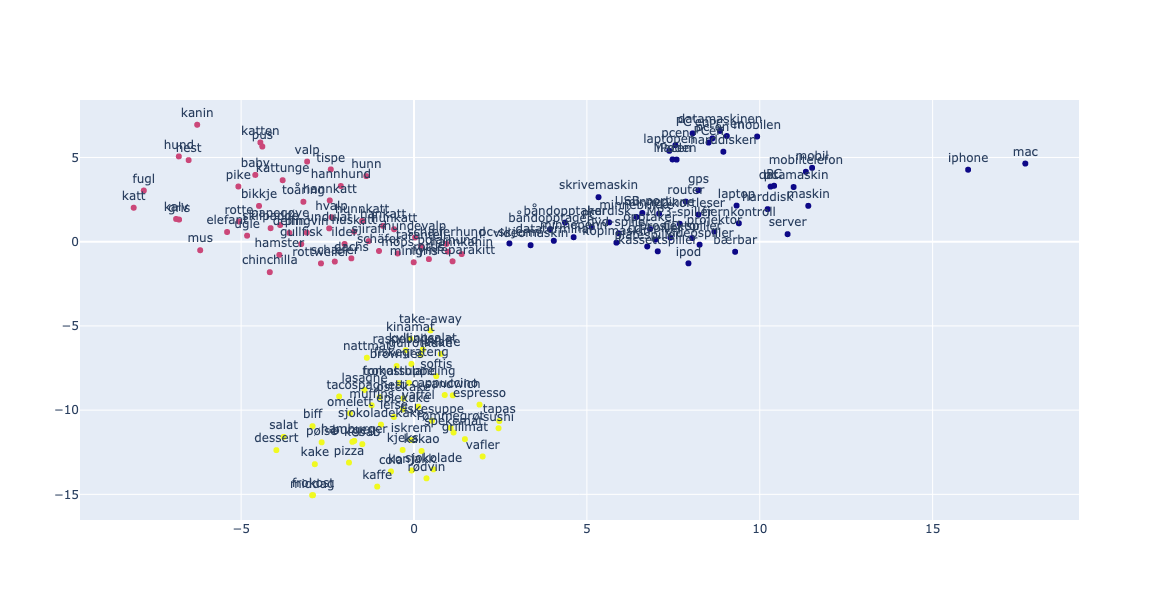

In [254]:
create_word_embeddings_fig_from_words(["pc", "katt", "pizza"], w2v_model, random_seed=10, layout=dict(width=800, height=600))

# Fra ord til dokumenter

- Merk at word embeddings genererer en vektor for hvert ord, men ikke direkte kan brukes for å transformere en hel tekt til tall
- Det er flere måter vi kan gå fra word embeddings til en representsasjon av et dokument:
    - Summere embeddingene for alle ord som finnes i tekstene (og normalisere)
    - Ta "max"/"min" av hver feature på tvers av ordene
    - Lære en modell for å transformere word embeddingene til én embedding for dokumentet. Typisk brukes et nevralt nett av typen CNN eller RNN (LSTM/BI-LSTM)
- Det finnes dessuten modeller for å lære embeddings for setninger/dokumenter direkte, som [sent2vec](https://rare-technologies.com/sent2vec-an-unsupervised-approach-towards-learning-sentence-embeddings/), [doc2vec](https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e), [StarSpace](https://github.com/facebookresearch/StarSpace), og mange andre

## Fra ord til dokumenter - summering av embeddings

In [216]:
text = "Det er en fin dag"
word_embs = [w2v_model[w] for w in text.split(" ")]
len(word_embs)

5

In [220]:
word_embs[0].shape

(100,)

In [226]:
doc_emb = np.sum(word_embs, axis=0)
doc_emb.shape

(100,)

In [227]:
doc_emb[:10]

array([ 3.3696392, -3.0866895,  3.9383595, 19.916162 ,  1.1578525,
        4.8926625, 21.05125  , -9.774063 ,  8.216241 ,  8.90777  ],
      dtype=float32)

## Fra ord til dokumenter - summering av embeddings

- Fordel: Alle ord vil ha noe å si for embeddingen til dokumentet
- Ulemper: 
    - For lange dokumenteter vil meningen "viskes" ut
    - Lave negative og høye positive verdier vil nulle ut hverandre

## Fra ord til dokumenter - max/min av features

In [236]:
doc_emb2 = np.max(word_embs, axis=0)
doc_emb2.shape

(100,)

In [237]:
doc_emb2[:10]

array([4.886674 , 1.625516 , 4.665564 , 7.651251 , 2.6525445, 2.4385333,
       7.1506896, 2.390927 , 7.4134874, 5.337118 ], dtype=float32)

Eller både min og max:

In [239]:
doc_emb3 = np.min(word_embs, axis=0)
doc_emb4 = np.hstack([doc_emb2, doc_emb3])
doc_emb4.shape

(200,)

## Fra ord til dokumenter - max/min av features

- Fordel: høye positive og lave negative vil ikke null ut hverandre (om man bruker både min og max)
- Ulempe: Siden kun max/min verdiene brukes vil ikke alle ordene påvirke resultatet. Si f.eks. at for én bestemt feature har 10 ord en høy verdi - med min/max vil ikke denne featuren vektes 10 ganger opp

## En wrapper for å bruke dette i NLP-pipelinen din

In [241]:
vec = TfidfVectorizer()
doc_vec = DocVectorizer(vec, w2v_model)

In [247]:
texts = ["Dette er en tekst", "Dette er en annen tekst", "Foo bar baz"]
texts_vec = doc_vec.fit_transform(texts)

In [248]:
texts_vec.shape

(3, 100)

In [246]:
vec_similarity(texts_vec[0], texts_vec[1])

Similarity: 92.02%


In [249]:
vec_similarity(texts_vec[0], texts_vec[2])

Similarity: 2.13%


# Contextualized word embeddings

- En utfordring med tradisjonelle WE er som nevnt én representasjon per ord
- Det siste året har det kommet flere arkitekturer som kan genrerere såkalte "contextualized word embeddings", hvor ord får ulik representasjon avhengig av hvilken kontekst det brukes i
- F.eks. vil ordet *bank* få ulik representasjon i setningen "Jeg skal gi deg bank", "Han jobbet i en bank"
- Noen arkitekturer for CWE: BERT, ELMO og Flair

# Tips for tekstrepresentasjoner

## Tips 1: Stacking av ulike tekstrepresentasjoner
- Man er ikke nødt til å holde seg til kun én representasjon for teksten
- Det er ingenting i veien for å "stacke" flere ulike tall-representasjoner av teksten
- F.eks. har jeg av erfaring sett at det for norsk funker bra å stacke ord-representasjoner (bigrams) med karakter-representasjoner

Stacking av representasjoner kan gjøres på følgende måte:

In [289]:
word_vec = CountVectorizer(ngram_range=(1, 2), analyzer="word")
char_vec = CountVectorizer(ngram_range=(4,4), analyzer="char_wb")
vec = make_union(word_vec, char_vec)

texts = ["språkprossesering", "prosessering av språk"]
texts_vec = vec.fit_transform(texts)
all_feature_names = [n for sub_vec in vec.transformer_list for n in sub_vec[1].get_feature_names()]
pd.DataFrame(texts_vec.todense(), columns=all_feature_names)

,av,av språk,prosessering,prosessering av,språk,språkprossesering,av,pro,spr,erin,...,ross,råk,råkp,seri,sese,sess,språ,sser,sses,åkpr
0,0,0,0,0,0,1,0,0,1,1,...,1,0,1,1,1,0,1,0,1,1
1,1,1,1,1,1,0,1,1,1,1,...,0,1,0,1,0,1,1,1,0,0


Noter: Her har jeg brukt CountVectorizer, fordi outputen gir mer mening, men i praksis funker vedlig ofte TfidfVectorizer bbedre.

## Tips 2: Én vektor per del av teksten

- For noen problemstillinger vil et ord ha ulik betydnig avhengig av hvilken del av teksten det brukes
- For eksempel kan ord i tittlen av en tekst ha spesiell betydning, og være lurt å representere med en egen vektor
- Av erfaring funker det ofte godt å bruke:
    - Én vektor for hele teksten (for å få riktig vekting av ord som brukes flere ganger, men bare én gang i hver del av teksten)
    - Vektorer for andre deler av teksten som bærer *spesielle* signaler for maskinlæringsproblemet

La oss først lage litt enkel tekst data, med flere felter, og en kolonne for den komplette teksten:

In [290]:
df_texts = pd.DataFrame({
    "title": ["Problem", "Bestilling av pizza"],
    "body": ["Hei. Jeg har problem med å komme inn på pcen min", "Kan jeg få en pizza med ekstra ost?"]
})
df_texts["text"] = df_texts[["title", "body"]].apply(lambda x: ". ".join(x), axis=1)
df_texts

,title,body,text
0,Problem,Hei. Jeg har problem med å komme inn på pcen min,Problem. Hei. Jeg har problem med å komme inn ...
1,Bestilling av pizza,Kan jeg få en pizza med ekstra ost?,Bestilling av pizza. Kan jeg få en pizza med e...


Om du bruker pandas for dataen kan du nå enkelt få til én vektor per tekst-del ved å bruke pakken ```sklearn_pandas```:

In [291]:
mapper = DataFrameMapper([
    ('title', CountVectorizer()), ('text', CountVectorizer())
], sparse=True)

texts_vec = mapper.fit_transform(df_texts)
all_feature_names = [f"{n} ({fname})" for fname, sub_vec in mapper.features for n in sub_vec.get_feature_names()]
pd.DataFrame(texts_vec.todense(), columns=all_feature_names)

,av (title),bestilling (title),pizza (title),problem (title),av (text),bestilling (text),ekstra (text),en (text),få (text),har (text),...,jeg (text),kan (text),komme (text),med (text),min (text),ost (text),pcen (text),pizza (text),problem (text),på (text)
0,0,0,0,1,0,0,0,0,0,1,...,1,0,1,1,1,0,1,0,2,1
1,1,1,1,0,1,1,1,1,1,0,...,1,1,0,1,0,1,0,2,0,0


## Tips 3: Vekting av ord

- Om man velger å behandle hele teksten som én vektor kan det noen ganger være lurt å vekte ord ulikt avhengig av hvilken del av teksten de kommer fra.
- Dette kan selvsagt også brukes om man har annen informasjon enn "del av teksten" for å avgjøre ord som bør legges mer vekt på
- Den enkleste måten å vektlegge ord/deler av tekst er, rett og slett, å duplikere de ordene/delene som skal vektlegges høyere (på langt nær mest effektive måten å gjøre det på, men funker)

In [284]:
title = "Hei "
body = "Hvordan går det?"
text = 2 * title + body
text

'Hei Hei Hvordan går det?'

In [288]:
vec = CountVectorizer()
text_vec = vec.fit_transform([text])
pd.DataFrame(text_vec.todense(), columns=vec.get_feature_names())

,det,går,hei,hvordan
0,1,1,2,1


## Tips 4: Andre tekst-features for modellen

- Det kan være lurt å tenkte på om man kan genrerere andre features fra tekten som kan gi nyttige signaler til maskinlæringsmodellen
- For eksempel:
    - Lengde på tekst
    - Ratio av ord med bare store bokstaver vs. vanlige ord, tegn vs. ord, tall vs. ord
    - Type dokument - e-post, tweet, nyhetsartikkel, scan etc.

# Visualisering av tekst

In [298]:
texts = df[["title", "body"]].apply(lambda x: "\n".join(x), axis=1)
labels = df.label

## Word clouds

In [303]:
# Pre-compute all word clouds
word_clouds = {}
for l in labels.unique():
    print(f"Generting word cloud for {l}")
    all_text = " ".join(texts[labels == l].str.lower())
    word_clouds[l] = WordCloud(width=800,height=600, background_color="white", stopwords=STOP_WORDS).generate(all_text)

Generting word cloud for Data > Brukerbidrag > Arbeidslogger (data og elektronikk)
Generting word cloud for Data > Brukerbidrag > Arbeidslogger (data og elektronikk) - Kommentarer
Generting word cloud for Data > Brukerbidrag > Brukertester
Generting word cloud for Data > Butikker og verksteder (data)
Generting word cloud for Data > Datamaskiner
Generting word cloud for Data > Hjelp til kjøp og salg av  PC
Generting word cloud for Data > IKT-drift og sikkerhet
Generting word cloud for Data > Internett og nettverk
Generting word cloud for Data > Internett og nettverk > Bredbånd og andre internett-tilkoblinger
Generting word cloud for Data > Internett og nettverk > Hjemmenettverk
Generting word cloud for Data > Operativsystemer
Generting word cloud for Data > Maskinen fungerer ikke
Generting word cloud for Data > Datautstyr
Generting word cloud for Data > Datautstyr > Elektronikk
Generting word cloud for Data > Datautstyr > Hovedkort
Generting word cloud for Data > Datautstyr > Kabinetter

Generting word cloud for Samfunn > Politikk og samfunn > Terrorangrepet i Oslo og på Utøya
Generting word cloud for Samfunn > Politikk og samfunn > Stortingsvalg 2017
Generting word cloud for Samfunn > Politikk og samfunn > Løvebakken
Generting word cloud for Samfunn > Politikk og samfunn > Spørretimen
Generting word cloud for Samfunn > Politikk og samfunn > Debattimen
Generting word cloud for Samfunn > Økonomi
Generting word cloud for Samfunn > Økonomi > Bedriftsøkonomi og ledelse
Generting word cloud for Samfunn > Økonomi > Privatøkonomi
Generting word cloud for Teknologi og vitenskap > Energi
Generting word cloud for Teknologi og vitenskap > Klima, naturfenomen og naturvern
Generting word cloud for Teknologi og vitenskap > Naturvitenskap
Generting word cloud for Teknologi og vitenskap > Samferdsel og infrastruktur
Generting word cloud for Teknologi og vitenskap > Samfunnsvitenskap
Generting word cloud for Teknologi og vitenskap > Annen teknologi og vitenskap
Generting word cloud for

In [309]:
def plot_word_cloud(category):
    word_cloud = word_clouds[category]
    plt.figure( figsize=(12,6) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show();

In [310]:
interact(plot_word_cloud, category=labels.unique().tolist());

interactive(children=(Dropdown(description='category', options=('Data > Brukerbidrag > Arbeidslogger (data og …

## Hva kan word clouds fortelle deg?

- Det gir et godt inntrykk av hvilke ord som brukes for hver kategori. Hvis ordene for to kategorier er veldig like, kan det indikere at maskinlæring vil slite med å skille mellom disse kategoriene.
- Det gir deg nyttig informasjon for å definere eller forbedre listen over *stop words* - vanlige ord i vokabularet som du ikke ønsker å ha med i tekst-representasjonen din (mer om dette senere).

## Scatterplot av tekster

In [377]:
labels.unique()

array(['Data > Brukerbidrag > Arbeidslogger (data og elektronikk)',
       'Data > Brukerbidrag > Arbeidslogger (data og elektronikk) - Kommentarer',
       'Data > Brukerbidrag > Brukertester',
       'Data > Butikker og verksteder (data)', 'Data > Datamaskiner',
       'Data > Hjelp til kjøp og salg av  PC',
       'Data > IKT-drift og sikkerhet', 'Data > Internett og nettverk',
       'Data > Internett og nettverk > Bredbånd og andre internett-tilkoblinger',
       'Data > Internett og nettverk > Hjemmenettverk',
       'Data > Operativsystemer', 'Data > Maskinen fungerer ikke',
       'Data > Datautstyr', 'Data > Datautstyr > Elektronikk',
       'Data > Datautstyr > Hovedkort',
       'Data > Datautstyr > Kabinetter og modifikasjoner',
       'Data > Datautstyr > Kjøling',
       'Data > Datautstyr > Kjøling > Kjøling - Vann og ekstrem',
       'Data > Datautstyr > Lagringsmedier',
       'Data > Datautstyr > Lydkort og PC-høyttalere',
       'Data > Datautstyr > Minne',
       'D

In [376]:
vec = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=.5, stop_words=STOP_WORDS)
labels_subset = ["Data > Datautstyr > Skjermkort og TV-kort", "Samfunn > Juss", "Jobb og utdanning > IT-utdanning"]
ix = labels.isin(labels_subset)
fig = create_text_scatter_plots(texts[ix], labels[ix], vec)
fig

    'data': [{'marker': {'opacity': 0.8, 'size': 10, 'symbol': 'circle'},
      …

## Hva kan scatterplots fortelle deg?

- Én av de viktigste tingene du kan få ut av slike scatterplots er idé om hvilke caser modellen din muligens vil ha problemer med å klassifisere riktig.
- Dette kan videre hjelpe deg å designe gode måter å forhåndsprosessere data, droppe datapunkter etc.

# Scattertext - "2d word clouds"

- Dokumentasjon kan du finne [her](https://github.com/JasonKessler/scattertext#overview)
- Scattertext gir deg ikke bare en plottefunksjon, men også all data som vises i plottet via Python APIet

In [71]:
_df = df.copy()
_df["trening_or_data"] = None
_df["trening_or_data"][_df.label.str.startswith("Data")] = "Data"
_df["trening_or_data"][_df.label.str.startswith("Fotball")] = "Trening"
_df = _df.groupby("trening_or_data", group_keys=False).apply(lambda x: x.sample(min(len(x), 200))) # Stratified sample of n instances
_df["text"] = _df[["title", "body"]].apply(lambda x: ". ".join(x), axis=1)
_df.shape

(400, 9)

In [77]:
file_name = "../resources/scattertext/diskusjonno-datavsikke.html"

In [16]:
corpus = st.CorpusFromPandas(_df, category_col="trening_or_data", text_col="text", nlp=nlp).build()

html = st.produce_scattertext_explorer(
    corpus,
    category="Data",
    #category_name="Data", not_category_name="Ikke Data",
    width_in_pixels=1000    
)

Path(file_name).parent.mkdir(exist_ok=True, parents=True)
with open(file_name, "w", encoding="utf8") as f:
    f.write(html)

NameError: name '_df' is not defined

In [76]:
IFrame(src=file_name, width = 1200, height=700)

# Forhåndsprosessering av teksten
- Forhåndsprosessering (en: pre-processing) av teksten vil si alt du gjør *før* teksten blir enkodet vektorisert
- Forhåndsprossesering handler om å:
    - Fjerne deler av teksten som kan forstyrre maskinlæringsmodellen
    - Endre deler av teksten for å sende andre/sterkere signaler til modellen
    - Legge til tekst som kan være nyttig for modellen

## Vanlige former for forhåndsprosessering

- Fjerning av "stop words"
- Fjerning av tegnsetting
- Standardisering:
    - "lowercasing"
    - lemmatisering og stemming
    - Erstatting av synonymer
- Fjerning av "deler av teksten"
- Retting av stavefeil
- Splitting av sammensatte ord

### Viktig!

Tenk på hvordan du henter ut ord i vekotriseringsalgoritmen din. Hvis du f.eks. ser etter kun sammenhengende bokstaver (```"\w+"```) (som er default for ```CountVectorizer``` og ```TfidfVectorizer```) så er det unødvendig å fjerne tegnsetting på forhånd - det vil ikke plukkes opp av mønsteret som ser etter ord uansett.

## Men, først - regex

- Regex er et språk for å definere mønstre i tekst
- Regex er muligens et av de mest nyttige verktøyene lære seg når man skal jobbe med tekstdata
- Du kan bruke det for å:
    - Matche en tekst med et mønster
    - Søke etter mønster i en tekst
    - Erstatte mønster i tekst
- Alle disse oppgavene vil ofte kreve *mye* kode å få til uten regex

### Regex: matche tekst

In [78]:
url_pattern = "https?://\S+"

In [79]:
match = re.match(url_pattern, "https://stackoverflow.com/")
match is not None

True

In [80]:
match = re.match(url_pattern, "Sjekk denne siden: https://stackoverflow.com/")
match is not None

False

### Regex: søke etter tekst 

In [81]:
match = re.search(url_pattern, "Sjekk denne siden: https://stackoverflow.com/")
match is not None

True

For å få teksten fra en match:

In [93]:
match.group()

'https://stackoverflow.com/'

In [82]:
def find_in_series(pd_series, pattern):
    ix = pd_series.str.contains(pattern)
    for text in pd_series[ix]:
        yield text

La oss søke gjennom tekstene etter URLer:

In [181]:
url_match_gen = find_in_series(df.body, url_pattern)

In [182]:
text = next(url_match_gen)
print_with_highlighting(text, url_pattern, is_pattern=True)

Det er blitt veldig populært  med worklogger og bra er det , men ikke alle ser ut til å være klar over hva som må til , derfor ender en del av disse i "grøfta" .

 Hva skal jeg lage ? 
Det første en bør gjøre er å tenke gjennom hva man vil lage og finne ut om man er i stand til dette ,har man materialer som trengs og ikke minst verktøy .
En annen viktig ting er , har man råd til dette , nevner det bare siden en del prosjekter strander på økonomi .

 Arbeidstegning 
Så er det lurt å lage en grovskisse og sette på de aktuelle mål , deretter er det lurt å prøve å tegne dette i målestokk, da får en et inntrykk av utseende på dette.

Neste skritt bør være å overføre dette til et tegneprogram ,her er sketchup å anbefale .
http://www.sketchup....ore/trybuy.html

Ved å bruke dette får du et 3 dimensjonalt inntrykk av din påtenkte prosjekt og kan dermed se feil/mangler før du begynner, i tillegg kan du her prøve ut forskjellige løsninger for å finne den du liker best .

 Selve prosjektet 
Når d

### Regex: erstatte text

In [92]:
re.sub(url_pattern, "[URL BLOCKED]", "Sjekk denne siden: https://stackoverflow.com/")

'Sjekk denne siden: [URL BLOCKED]'

Eller med en "callable"

In [95]:
re.sub("ha", lambda x: x.group().upper(), "Det var morsomt hahaha")

'Det var morsomt HAHAHA'

### Gode ressurser for å lære og teste regex

- [RegexOne](https://regexone.com/) for å lære regex
- [regex101](https://regex101.com/) for å teste regex (husk å skifte til Python i kolonnen til venstre)

# Fjerning av "stop words"

- "Stop words" er alle ord man mener ikke er relevant for problemet vi skal løse
- Vanligvis brukes en liste over de mest vanlige ordene i språket som et utgangspunkt
- **Sørg for å tilpasse denne listen problemet du skal løse. Det kan være ord i listen du absolutt ikke ønsker å fjerne, og det kan være andre ord som ikke finens i listen du ønsker å fjerne**

Merk: idf-delen av Tf-idf vil til en viss grad vekte ned veldig vanlige ord, men nedvektingen er ofte ikke tilstrekkelig - spesielt med lite data. Med *mye* data kan derimot Tf-idf være godt nok.

## Stop words fra Spacy

In [153]:
STOP_WORDS

{'alle',
 'allerede',
 'alt',
 'and',
 'andre',
 'annen',
 'annet',
 'at',
 'av',
 'bak',
 'bare',
 'bedre',
 'beste',
 'blant',
 'ble',
 'bli',
 'blir',
 'blitt',
 'bris',
 'by',
 'både',
 'da',
 'dag',
 'de',
 'del',
 'dem',
 'den',
 'denne',
 'der',
 'dermed',
 'det',
 'dette',
 'disse',
 'drept',
 'du',
 'eller',
 'en',
 'enn',
 'er',
 'et',
 'ett',
 'etter',
 'fem',
 'fikk',
 'fire',
 'fjor',
 'flere',
 'folk',
 'for',
 'fortsatt',
 'fotball',
 'fra',
 'fram',
 'frankrike',
 'fredag',
 'funnet',
 'få',
 'får',
 'fått',
 'før',
 'først',
 'første',
 'gang',
 'gi',
 'gikk',
 'gjennom',
 'gjorde',
 'gjort',
 'gjør',
 'gjøre',
 'god',
 'godt',
 'grunn',
 'gå',
 'går',
 'ha',
 'hadde',
 'ham',
 'han',
 'hans',
 'har',
 'hele',
 'helt',
 'henne',
 'hennes',
 'her',
 'hun',
 'hva',
 'hvor',
 'hvordan',
 'hvorfor',
 'i',
 'ifølge',
 'igjen',
 'ikke',
 'ingen',
 'inn',
 'ja',
 'jeg',
 'kamp',
 'kampen',
 'kan',
 'kl',
 'klart',
 'kom',
 'komme',
 'kommer',
 'kontakt',
 'kort',
 'kroner',
 

In [154]:
def count_all_words(texts):
    counter = Counter()
    for text in texts:
        counter.update(re.findall("[^\W_]+", text))
    return counter

Mest vanlige ord i tekstene våre fra diskusjon.no:

In [166]:
all_text = df[["title", "body"]].apply(lambda x: " ".join(x), axis=1).str.lower()
word_counter = count_all_words(all_text)

In [171]:
word_counter.most_common(20)

[('og', 46923),
 ('er', 45855),
 ('jeg', 43536),
 ('det', 38901),
 ('på', 38610),
 ('i', 36178),
 ('som', 31167),
 ('å', 31051),
 ('en', 30535),
 ('har', 29878),
 ('til', 27306),
 ('med', 24220),
 ('for', 21835),
 ('ikke', 19819),
 ('av', 18005),
 ('at', 16645),
 ('men', 14854),
 ('så', 13788),
 ('om', 13418),
 ('den', 13050)]

In [168]:
def most_common_not_in_collection(counter, _collection, n=10):
    result = []
    for word, count in counter.most_common():
        if word in _collection:
            continue
        result.append((word, count))
        if len(result) == n:
            break
    return result

In [172]:
most_common_not_in_collection(word_counter, STOP_WORDS, 20)

[('2', 4983),
 ('1', 4938),
 ('hei', 4335),
 ('the', 3884),
 ('min', 3838),
 ('3', 3737),
 ('5', 2853),
 ('4', 2832),
 ('10', 2746),
 ('vet', 2671),
 ('dere', 2513),
 ('www', 2509),
 ('no', 2293),
 ('hvis', 2263),
 ('bruke', 2095),
 ('trenger', 2060),
 ('pc', 2032),
 ('jo', 1948),
 ('tv', 1933),
 ('https', 1862)]

Erstatting av stopwords direkte under vektorisering:

In [189]:
text = "Dette er en tekst med mye støy"
vec = CountVectorizer(stop_words=STOP_WORDS)
text_vec = vec.fit_transform([text])
pd.DataFrame(text_vec.todense(), columns=vec.get_feature_names())

,støy,tekst
0,1,1


Med en egen transformer:

In [179]:
StopwordRemover(STOP_WORDS).fit_transform([text])

['      tekst     støy']

Regex-baserte stop words:

In [180]:
re_stop_words = ["bil(e(r|ne?))?"]
RegexStopwordRemover(re_stop_words).fit_transform(["En bil, bilen, flere biler, alle bilene"])

['En  ,  , flere  , alle  ']

# Fjerning av tegnsetting

- Avhengig av hva som er token-mønsteret ditt er muligens dette ikke nødvendig
- For for eksempel "char n-grams" fra ```CountVectorizer``` eller ```TfidfVectorizer``` kan dog dette være lurt

In [188]:
text = "Hei :) Hvordan går det?"
punct_patterns = ["\W"]
RegexStopwordRemover(punct_patterns).fit_transform([text])

['Hei    Hvordan går det ']

# Oversetting av ord

In [33]:
text = "Et foredrag om NLP. Et foredrag om naturlig språkprossesering"
vec = CountVectorizer()
text_vec = vec.fit_transform([text])
pd.DataFrame(text_vec.todense(), columns=vec.get_feature_names())

,et,foredrag,naturlig,nlp,om,språkprossesering
0,2,2,1,1,2,1


In [44]:
replacements = {"naturlig språkprossesering": "nlp"}
vec = CountVectorizer()
pipeline = make_pipeline(RegexReplacer(replacements), vec)
text_vec = pipeline.fit_transform([text])
pd.DataFrame(text_vec.todense(), columns=vec.get_feature_names())

,et,foredrag,nlp,om
0,2,2,2,2


# Lowercasing

In [192]:
text = "norge Norge"
vec = CountVectorizer(lowercase=False)
text_vec = vec.fit_transform([text])
pd.DataFrame(text_vec.todense(), columns=vec.get_feature_names())

,Norge,norge
0,1,1


In [195]:
text = "norge Norge"
vec = CountVectorizer(lowercase=True)
text_vec = vec.fit_transform([text])
pd.DataFrame(text_vec.todense(), columns=vec.get_feature_names())

,norge
0,2


## Lowercasing - ikke alltid en god idé

In [196]:
text = "I love it. I love IT."
vec = CountVectorizer(lowercase=True)
text_vec = vec.fit_transform([text])
pd.DataFrame(text_vec.todense(), columns=vec.get_feature_names())

,it,love
0,2,2


## Lowercasing av alt bortsett fra egennavn

In [30]:
def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [str(word).lower() if word.pos_ != "PROPN" else str(word) for word in mytokens]
    return mytokens

In [29]:
vec = CountVectorizer(tokenizer=spacy_tokenizer, lowercase=False)
texts = ["Jeg så en bjørn", "Jeg heter Bjørn"]
texts_vec = vec.fit_transform(texts)
pd.DataFrame(texts_vec.todense(), columns=vec.get_feature_names())

['X', 'VERB', 'X', 'NOUN']
['X', 'VERB', 'PROPN']


,Bjørn,bjørn,en,heter,jeg,så
0,0,1,1,0,1,1
1,1,0,0,1,1,0


# Lemmatisering og stemming

- Lemmatisering og stemming er begge teknikker for å finne roten av ord
- **Stemming**: en liste over vanlige endinger brukes for å kutte enden av ordet
- **Lemmatization**: gramatiske regler og ordbøker brukes for å bedre finne roten av ordet
- Ved å bruke dette vil f.eks. "bil", "bilen", "biler" og "bilene" alle bli transformert til roten "bil"

In [50]:
text = "Jeg har en bil. Han har flere biler."
print(" ".join(word.lemma_ for word in nlp(text)))

Jeg har en bil . Han har fler bil .


# Automatisk splitting av sammensatte ord

- Norsk er et språk med veldig mange sammensatte ord, noe som kan skape trøbbel for ord-basert NLP
- Om man kun bruker ord-baserte vektorer, kan det være lurt å teste med å automatisk splitte sammensatte ord
- Jeg har holdt en presentasjon om dette tidkigere som du kan finne [her](https://github.com/peterts/something-some-thing/blob/master/Something%20Some%20Thing.ipynb)

# Visualisering av ord som er fjernet og ord som er lagt til

Det er veldig lurt å teste prosesseringen sin ved å visualisere teksten før og etter forhåndprosessering:

In [187]:
text_original = "Sjekk denne siden: https://stackoverflow.com/"
text_trans = re.sub(url_pattern, "[URL BLOCKED]", text_original)
text_diff(text_original, text_trans)

# Maskinlæring for NLP

<center> <img src="../images/finally.jpg"/> </center>

- Har du kommet så langt, er egentlig det meste gjort
- Å trene en maskinlæringsmodell for klassifisering krever nå bare noen få linjer kode
- Å fintune modellen krever selvsagt mer kode enn dette, men det er ikke tema for denne presentasjonen

Tilpassing av en modell:

In [98]:
clf = LogisticRegression(multi_class="auto")
# clf = LinearSVC()
# clf = MultinomialNB()
# clf = SGDClassifier(loss="log")  # Logistic regression suitable for "bigger" datasets
# clf = SGDClassifier(loss="hinge")  # SVM (SVC) suitable for "bigger" datasets

In [ ]:
%%time
vec = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=.5)
texts = df[["title", "body"]].apply(lambda x: " ".join(x), axis=1)
X = vec.fit_transform(texts)
y = df.label
clf.fit(X, y)

In [58]:
text = ["Oppgraderte PCen med en gtx 2080 ti"]
X_test = vec.transform(text)
clf.predict(X_test)[0]

'Data > Datautstyr > Skjermkort og TV-kort'

# Pipelines

- Om du følger koden over, ser du at vi må gjennom samme steg når vi tilpasser modellen (```.fit```), og når vi tester modellen (```.predict```):
    - Først må vi gjøre teksten om til tall
    - Deretter må vi trene/predikere (med) modellen
- For NLP kan disse sekvensene av steg ofte bli mye lenger, noe som kompliserer koden over
- Det kan derfor være lurt å lage *transformers* for alle steg du vil ha med i prosesseringen, og putte alle disse i en pipeline
- En baseklasse for en tekstrense-transformer kan du finne i ```nlp_intro.transformers.ABCTextCleaner```

In [95]:
pipeline = make_pipeline(
    RegexStopwordRemover([r"https?://\S+"]),
    TfidfVectorizer(ngram_range=(4,4), analyzer="char", min_df=3, max_df=.5),
    LogisticRegression()
)

In [ ]:
%%time
pipeline.fit(texts, y);

In [99]:
pipeline.predict(text)[0]

'Data > Datautstyr > Skjermkort og TV-kort'

Merk at vi ikke bruker tall-representasjonen av tekstene (```X```) når vi nå kaller pipelinen

# Testing av modellen

Når vi tester modellen er vi for det første nødt til å splitte tekstene i et trenings- og testsett:

In [79]:
value_counts = y.value_counts()
ix = y.isin(value_counts[value_counts >= 10].index)
y2 = y[ix]
texts2 = texts[ix]
texts_train, texts_test, labels_train, labels_test = train_test_split(texts2, y2, test_size=.1, stratify=y2)

In [80]:
len(texts_train), len(labels_train)

(13960, 13960)

In [81]:
len(texts_test), len(labels_test)

(1552, 1552)

In [87]:
labels_train.value_counts().sort_index().iloc[:5]

Data > Brukerbidrag > Arbeidslogger (data og elektronikk)                  90
Data > Brukerbidrag > Arbeidslogger (data og elektronikk) - Kommentarer    90
Data > Brukerbidrag > Brukertester                                         90
Data > Butikker og verksteder (data)                                       90
Data > Datamaskiner                                                        90
Name: label, dtype: int64

In [88]:
labels_test.value_counts().sort_index().iloc[:5]

Data > Brukerbidrag > Arbeidslogger (data og elektronikk)                  10
Data > Brukerbidrag > Arbeidslogger (data og elektronikk) - Kommentarer    10
Data > Brukerbidrag > Brukertester                                         10
Data > Butikker og verksteder (data)                                       10
Data > Datamaskiner                                                        10
Name: label, dtype: int64

Vi vil nå trene modellen på kun treningsdata, og teste modellen på test data, får å gi et godt inntrykk av hvordand en vil funke på usett data:

In [96]:
pipeline.fit(texts_train, labels_train)

Pipeline(memory=None,
         steps=[('regexstopwordremover',
                 RegexStopwordRemover(case_sensitive=None, stopwords=None)),
                ('tfidfvectorizer',
                 TfidfVectorizer(analyzer='char', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=3, ngram_range=(4, 4), norm='l2',
                                 preprocesso...
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [90]:
def print_accuracy(real, pred):
    acc = (real == pred).mean()
    print(f"Accuracy: {acc*100:.2f}%")

In [100]:
labels_pred = pipeline.predict(texts_test)
print_accuracy(labels_test, labels_pred)

Accuracy: 51.42%


In [103]:
def chop_strings(strings, n):
    return [s[:n] for s in strings]

## Resultater for hver enkelt klasse

In [105]:
print(classification_report(chop_strings(labels_test,30), chop_strings(labels_pred,30)))

                                precision    recall  f1-score   support

Data > Brukerbidrag > Arbeidsl       0.61      0.70      0.65        20
Data > Brukerbidrag > Brukerte       0.44      0.40      0.42        10
Data > Butikker og verksteder        0.36      0.50      0.42        10
           Data > Datamaskiner       0.25      0.10      0.14        10
Data > Datautstyr > Annet om m       0.00      0.00      0.00        10
Data > Datautstyr > Elektronik       0.31      0.40      0.35        10
 Data > Datautstyr > Hovedkort       0.55      0.60      0.57        10
Data > Datautstyr > Kabinetter       0.53      0.80      0.64        10
   Data > Datautstyr > Kjøling       0.27      0.40      0.32        10
Data > Datautstyr > Kjøling >        0.46      0.60      0.52        10
Data > Datautstyr > Lagringsme       0.75      0.60      0.67        10
Data > Datautstyr > Lydkort og       0.50      0.60      0.55        10
     Data > Datautstyr > Minne       0.71      1.00      0.83  

## Hva forvirres?

In [109]:

iplot(create_confusion_matrix_fig(labels_test, labels_pred))

## En "forklaring" på prediksjonene

In [112]:
vec = pipeline.steps[1][1]

# Tips
- Generelt, desto mindre data du har, desto viktigere er det å hjelpe modellen med litt menenskelig kunskap ved å prosessere dataen på en måte vi vet gir mening

# Trender

- "Transfer learning" for nlp
- Kontekstualiserte embeddings
- Dyp læring (ikke alltid like suksessfullt)
- Nye arkitekturer som "Attention"

# Andre ressurser

- En annen god [tutorial](https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/)
- [norwegian-nlp-resources](https://github.com/web64/norwegian-nlp-resources) - en god liste over ressurser for nlp for norsk
- Flair - laget av Zalando som er et tysk selskap. Tysk har mange likheter med norsk, så dette er derfor en ganske spenennde pakke.
- [PyText](https://github.com/facebookresearch/pytext) (ikke testet)
- [TextBlob](https://github.com/sloria/TextBlob) (ikke testet, ingen støtte for norsk out-of-the-box)